---
title: "Chemical similarity with Python and RDKit"
author:
  - name: 
      given: Chase
      family: Clark
      non-dropping-particle: M
    roles: [original draft, review & editing]
    url: https://chasemc.github.io
    affiliation: University of Wisconsin-Madison
    orcid: 0000-0001-6439-9397
categories: [beginner, chemistry, python]
date: "2024-2-28"
description: "A very brief introduction to calculating chemical similarity"
draft: false
appendix-cite-as: display
funding: "The author(s) received no specific funding for this work."
citation: true
format:
  html:
    df-print: paged
    template-partials:
    - title-metadata.html
---

# Introduction

I recently reworked a portion of the [SocialGene](https://socialgene.github.io/) codebase to allow for easier addons/plugins. Inevitably, this also meant I needed to write additional code to accommodate chemistry into software that had primarily been genomics oriented. I won't go into details here but chemicals from any source (e.g. NPAtlas, GNPS standards, etc.) are linked to a standardized notion of a molecule (i.e. the same molecule from two sources will link to a single "chemical" node). But I also wanted chemical similarity to be incorporated. After incorporating some basic chemical similarity measures I realized that some molecules I wanted to see be linked as "similar" weren't and that led down a rabbit hole of similarity measures. LOng story short, there's going to be two, Tanimoto and a semi-custom MCS similarity (at the bottom of this post). However, they second takes a long time to compute, so I decided to pump out this quick, very introductory post on calculating chemical similarity. 


# Vectors

SocialGene now has a `ChemicalCompound` class that wraps some [RDKit](https://www.rdkit.org/) functionality.

For example given a chemical compound's InChI or smiles representation, it will create the RDKit object and auto-compute a bunch of properties that SocialGene uses in its graph. 

In [53]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, rdFMCS, Draw
from rich import inspect

inchi_string="InChI=1S/C37H67NO13/c1-14-25-37(10,45)30(41)20(4)27(39)18(2)16-35(8,44)32(51-34-28(40)24(38(11)12)15-19(3)47-34)21(5)29(22(6)33(43)49-25)50-26-17-36(9,46-13)31(42)23(7)48-26/h18-26,28-32,34,40-42,44-45H,14-17H2,1-13H3/t18-,19-,20+,21+,22-,23+,24+,25-,26+,28-,29+,30-,31+,32-,34+,35-,36-,37-/m1/s1"

mol1 = Chem.MolFromInchi(inchi_string)


In [54]:
inspect(mol1)


╭────────────── <class 'rdkit.Chem.rdchem.Mol'> ───────────────╮
│ The Molecule class.                                          │
│                                                              │
│ ╭──────────────────────────────────────────────────────────╮ │
│ │ <rdkit.Chem.rdchem.Mol object at 0x7fe211923d10>         │ │
│ ╰──────────────────────────────────────────────────────────╯ │
│                                                              │
│ 40 attribute(s) not shown. Run inspect(inspect) for options. │
╰──────────────────────────────────────────────────────────────╯

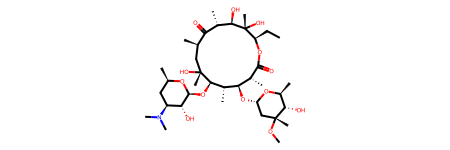

In [55]:
mol1


A lot (most?) methods to calculate chemical similarity don't work on the molecule itself, but a vector representation of the molecule (i.e. "vector"= a 1-dimensional set of numbers (e.g. [1,2,3,4,5])). 
The length of the vector and the means by which numbers are assigned vary, but a common method is the "Morgan Fingerprint".

The figure below is from  `Caichao Ye, Xinyue Zhang, Genwang Wei et al. Data-based Polymer-Unit Fingerprint (PUFp): A Newly Accessible Expression of Polymer Organic Semiconductors for Machine Learning, 20 July 2022, https://doi.org/10.21203/rs.3.rs-1813671/v1` and depicts several methods for creating these vectors (the boxes, where each square is a "bit" or number in the vector)

![Figure copied from: Caichao Ye, Xinyue Zhang, Genwang Wei et al. Data-based Polymer-Unit Fingerprint (PUFp): A Newly Accessible Expression of Polymer Organic Semiconductors for Machine Learning, 20 July 2022, https://doi.org/10.21203/rs.3.rs-1813671/v1](media/fingerprinting_ccby_4.png){fig-alt="Visual representation of different chemical fingerprinting methods."}

So, lets take a look at the Morgan fingerprint for our erythromycin molecule. 

In [56]:
mol1_morgan_fingerprint = AllChem.GetMorganFingerprintAsBitVect(
        mol1, useChirality=True, radius=2, nBits=2084, bitInfo={}
    )


In [57]:
mol1_morgan_fingerprint


In [58]:
mol1_morgan_fingerprint.ToBitString()


'000000000000000000000000000000000000000001000000000000000000000000100000000000000000000000000000000000000000100000000000000100000000000100000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000100000000000000000000000000010000000000000000000000000000000000000100000000000000000000000000000000100000100000000000001010000000000000000000000000000000000001000000000000000000000000100000000000000000000010000000000000010000000000000000000000000000010000000000000000000100001000000000000000000000000000000010000000000000000000000000000000000000000000000000000010000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000100000000000000000000000000100000000000000000000000000000000000001000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000001000000

The vector should have 2048 numbers

In [59]:
mol1_morgan_fingerprint.GetNumBits()


2084

How many 1's

In [60]:
mol1_morgan_fingerprint.GetNumOnBits()


72

How many 0's

In [61]:
mol1_morgan_fingerprint.GetNumOffBits()


2012

## Calculate similarity

Just like with fingerprint/vector generation, there are a lot of different methods to measure similarity between vectors.
For simplicity I'm just going to use RDKit's Tanimoto score.

And, obviously, if we calculate the similarity between the same vector we should get the best score possible which, for Tanimoto, is 1.

In [62]:
DataStructs.TanimotoSimilarity(mol1_morgan_fingerprint, mol1_morgan_fingerprint)


1.0


# Beyond Tanimoto

But Tanimoto similarity isn't always great. Two molecules I've been using to test things on the genetics side of Socialgene are Diazaquinomycin A and Nybomycin.
For my convenience I'm going to parse these 

In [63]:
diazaquinomycin_a_inchi = "InChI=1S/C20H22N2O4/c1-5-7-11-9(3)19(25)21-15-13(11)17(23)14-12(8-6-2)10(4)20(26)22-16(14)18(15)24/h5-8H2,1-4H3,(H,21,25)(H,22,26)"
nybomycin_inchi = "InChI=1S/C16H14N2O4/c1-8-3-13(21)18-7-22-16-14-11(5-10(8)15(16)18)9(6-19)4-12(20)17(14)2/h3-5,19H,6-7H2,1-2H3"


In [64]:
diazaquinomycin_a_mol = Chem.MolFromInchi(diazaquinomycin_a_inchi)
nybomycin__mol = Chem.MolFromInchi(nybomycin_inchi)


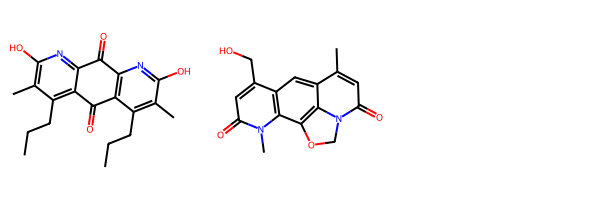

In [65]:
Draw.MolsToGridImage([diazaquinomycin_a_mol, nybomycin__mol])


In [66]:
def morgan_fingerprint(rdkitmol, radius=2, nBits=1024):
    return AllChem.GetMorganFingerprintAsBitVect(
                rdkitmol, useChirality=True, radius=radius, nBits=nBits, bitInfo={}
            )


In [67]:
diazaquinomycin_a_morgan_fingerprint = morgan_fingerprint(diazaquinomycin_a_mol)
nybomycin_morgan_fingerprint = morgan_fingerprint(nybomycin__mol)


In [68]:
DataStructs.TanimotoSimilarity(diazaquinomycin_a_morgan_fingerprint, nybomycin_morgan_fingerprint)


0.12903225806451613

In [69]:
DataStructs.DiceSimilarity(diazaquinomycin_a_morgan_fingerprint, nybomycin_morgan_fingerprint)


0.22857142857142856

However, these molecules, while definitely different, share common biosynthetic and structural elements and I wanted a score that could supplement other general scores.

# Maximum Common Substructure (MCS) similarity 

The code in the next block uses RDKit to find the maximum common substructure. I highly recommend [teachopencadd](https://projects.volkamerlab.org/teachopencadd/talktorials/T006_compound_maximum_common_substructures.html) for a good explainer on MCS, and other tutorials on computational chemistry.

In [70]:
molecules = [diazaquinomycin_a_mol, nybomycin__mol]
mcs_result = rdFMCS.FindMCS(molecules, ringMatchesRingOnly = True, completeRingsOnly=True)
mcs_smarts = mcs_result.smartsString
mcs_mol = Chem.MolFromSmarts(mcs_result.smartsString)
smarts_and_mols = [mcs_mol] + molecules
legends =  ["Maximum Common Substructure", "Diazaquinomycin A", "Nybomycin"]
matches = [""] + [mol.GetSubstructMatch(mcs_mol) for mol in molecules]


Visually this looks okay...

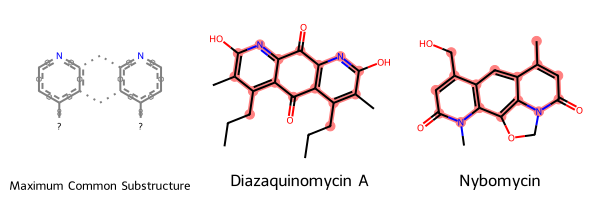

In [71]:
#| classes: preview-image 
drawing = Draw.MolsToGridImage(smarts_and_mols, highlightAtomLists=matches, legends=legends)
drawing


And we can calculate the Tanimoto similarity formula as applied to the shared vs unshared atoms of the two molecules and their maximum common substructure.

In [78]:
mcs_result.numAtoms / (diazaquinomycin_a_mol.GetNumAtoms() + nybomycin__mol.GetNumAtoms() - mcs_result.numAtoms)


0.5

Wrapping that into a single Pyhon function:

In [93]:
def mcs_similarity(mol1, mol2, threshold=0.3):
    res = rdFMCS.FindMCS((mol1, mol2),  timeout=5, ringMatchesRingOnly = True, completeRingsOnly=True)
    mcs_tani = res.numAtoms / (mol1.GetNumAtoms() + mol2.GetNumAtoms() - res.numAtoms)
    if mcs_tani >= threshold:
        return mcs_tani


In [94]:
mcs_similarity(diazaquinomycin_a_mol, nybomycin__mol)


0.5

## Caveat

While writing this NPatlas contains ~30,000 molecules. Using RDKit's "bulk" versions of tanimoto calculating an all-vs-all similarity takes a few minutes running in parallel on a 12-core processor (24 logical cores). However, MCS is a **lot** slower of a calculation. To calculate this MCS similarity on NPatlas required substantial time on CHTC, UW-Madison's Center for High Throughput Computing. Enough time for me to write this post, and more.